In [1]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import saraRC1 as sara

In [2]:
import numpy as np
from scipy.misc import face
from scipy.ndimage import zoom
from scipy.special import logsumexp
import torch

import deepgaze_pytorch

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# DEVICE = "cpu"

# you can use DeepGazeI or DeepGazeIIE
# model = deepgaze_pytorch.DeepGazeIIE(pretrained=True).to(DEVICE)

model = deepgaze_pytorch.DeepGazeIIE(pretrained=True).to(DEVICE)

c:\Users\matth\anaconda3\envs\sara\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\matth\anaconda3\envs\sara\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Loaded pretrained weights for efficientnet-b5


Using cache found in C:\Users\matth/.cache\torch\hub\pytorch_vision_v0.6.0
c:\Users\matth\anaconda3\envs\sara\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Using cache found in C:\Users\matth/.cache\torch\hub\pytorch_vision_v0.6.0
c:\Users\matth\anaconda3\envs\sara\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg

In [20]:
img = image = cv2.imread('./images/COTS Dataset/Part 2 - Multiple Objects/academic_book_no/3_colour.jpeg')

In [5]:
# image = face()
img_width = image.shape[1]
img_height = image.shape[0]

# Resize to half
# image = cv2.resize(image, (image.shape[1] // 2, image.shape[0] // 2))

# load precomputed centerbias log density (from MIT1003) over a 1024x1024 image
# you can download the centerbias from https://github.com/matthias-k/DeepGaze/releases/download/v1.0.0/centerbias_mit1003.npy
# alternatively, you can use a uniform centerbias via `centerbias_template = np.zeros((1024, 1024))`.
# centerbias_template = np.load('centerbias_mit1003.npy')
centerbias_template = np.zeros((1024, 1024))
# rescale to match image size
centerbias = zoom(centerbias_template, (image.shape[0]/centerbias_template.shape[0], image.shape[1]/centerbias_template.shape[1]), order=0, mode='nearest')
# renormalize log density
centerbias -= logsumexp(centerbias)

image_tensor = torch.tensor([image.transpose(2, 0, 1)]).to(DEVICE)
centerbias_tensor = torch.tensor([centerbias]).to(DEVICE)

log_density_prediction = model(image_tensor, centerbias_tensor)

saliency_map = cv2.resize(log_density_prediction.detach().cpu().numpy()[0, 0], (img_width, img_height))

# Save to img1.jpg
cv2.imwrite('saliency_map.jpg', saliency_map)


C:\Users\matth\AppData\Local\Temp\ipykernel_20700\1389178611.py:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  image_tensor = torch.tensor([image.transpose(2, 0, 1)]).to(DEVICE)


True

In [9]:
saliency_map -= saliency_map.min()  # Shift the minimum value to 0
saliency_map /= saliency_map.max()  # Normalize to [0, 1]
saliency_map *= 255                # Scale to [0, 255]
saliency_map = saliency_map.astype(np.uint8)  # Convert to unsigned 8-bit integer
cv2.imwrite('saliency_map.jpg', saliency_map, [cv2.IMWRITE_JPEG_QUALITY, 100])

True

In [2]:
saliency_map = cv2.imread('saliency_map.jpg')
saliency_map = cv2.cvtColor(saliency_map, cv2.COLOR_BGR2GRAY)

In [24]:
saliency_map_norm = cv2.normalize(saliency_map, None, 255, 0, cv2.NORM_MINMAX, cv2.CV_8UC1)

saliency_map_norm = cv2.GaussianBlur(saliency_map_norm, (31, 31), 10)
saliency_map_norm = saliency_map_norm // 16

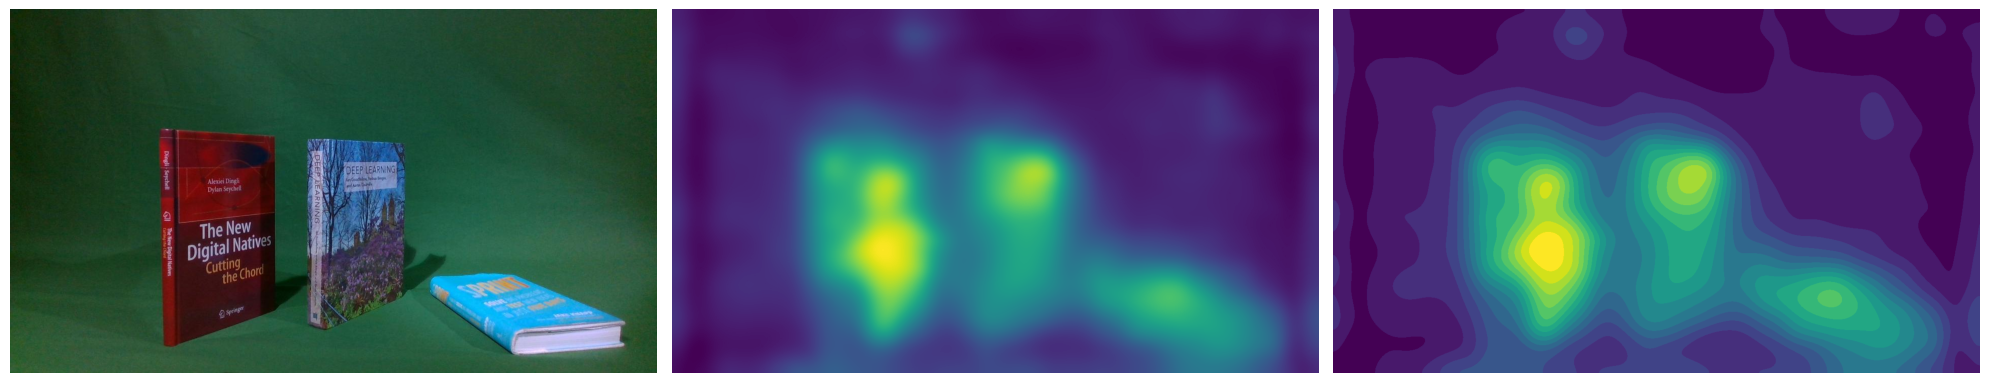

In [26]:
plt.figure(figsize=(20, 10))

plt.subplot(131)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(132)
plt.imshow(saliency_map, cmap='viridis')
plt.axis('off')

plt.subplot(133)
plt.imshow(saliency_map_norm, cmap='viridis')
plt.axis('off')


plt.tight_layout()

plt.show()